# 目的
本コードでは、パーシステントホモロジーという数学的な手法を用いて数字画像からトポロジー情報(穴の数やその明確さ)を取り出すことで、数字予測に有用な特徴量を作成することを目的とする。

例えば0,6,8,9といった数字は輪っかとして閉じている部分があり、これをトポロジー情報として検出することで特徴量を作成しようという試みである。(今回はh1情報のみを扱う)

#使用ライブラリ
パーシステントホモロジー計算にはgudhiを、画像データにはmnist、画像処理にはscipyを用いた。

In [2]:
from sklearn.datasets import fetch_openml
from scipy.ndimage import grey_dilation
from scipy.ndimage import gaussian_filter
from scipy.ndimage import binary_dilation
from scipy.ndimage import distance_transform_edt
import numpy as np
import matplotlib.pyplot as plt
!pip install gudhi
import gudhi

mnist = fetch_openml('mnist_784', version=1, parser='auto')
X, y = mnist.data, mnist.target

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 12.4 MB/s eta 0:00:00


#処理関数

具体的に、画像を2値化したのち、距離関数により、背景に文字からの最短距離によってグラデーションをつけた。
また、出力された1次情報から上位2つの情報を用いることで、その画像の穴の数を推定することを試みた。

In [3]:
def show_image(image):
    plt.figure(figsize=(4, 4))
    plt.imshow(image.reshape(28, 28), cmap='gray')
    plt.axis('off')
    plt.show()


def extract_topology_features(image,show=False):
    img = image.reshape(28, 28)
    binary = img > 126
    distance_map = distance_transform_edt(~binary)
    if distance_map.max() > 0:
        distance_normalized = (distance_map / distance_map.max() * 255).astype(float)
    else:
        distance_normalized = distance_map

    if show:
        print("反転のみ")
        show_image(img)
        print("二値化")
        show_image(binary)
        print("距離変換")
        show_image(distance_normalized)

    cc = gudhi.CubicalComplex(
        dimensions=distance_normalized.shape,
        top_dimensional_cells=distance_normalized.flatten()
    )
    persistence = cc.persistence()

    h1_pairs = [(birth, death) for dim, (birth, death) in persistence
                if dim == 1 and death != float('inf')]
    h1_lifetimes = [death - birth for birth, death in h1_pairs]
    n=len(h1_lifetimes)
    longest=0
    long=0
    for i in range(n):
        if longest<=h1_lifetimes[i]:
            long=longest
            longest=h1_lifetimes[i]
        elif long<=h1_lifetimes[i]:
            long=h1_lifetimes[i]
    return longest,long


# 画像処理の例

反転のみ


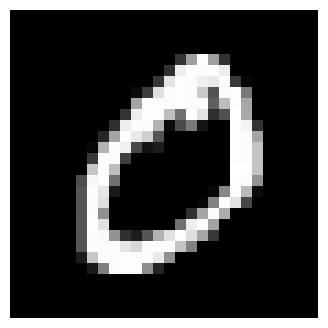

二値化


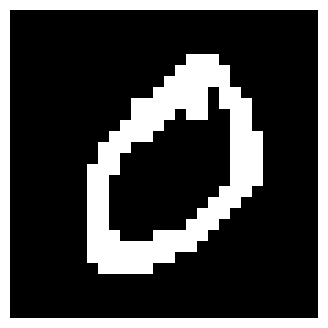

距離変換


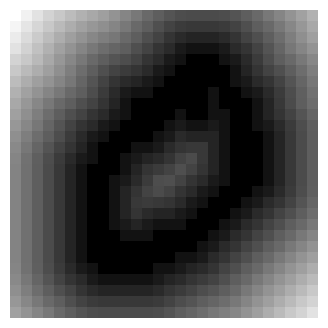

(79.54091247123554, 11.94413500126791)

In [7]:
extract_topology_features(X.iloc[1].values,show=True)

# 分析結果

In [6]:
ans=[[0,0,0] for i in range(10)]
for i in range(len(X)):
    l,s=extract_topology_features(X.iloc[i].values)
    label = int(y.iloc[i])
    ans[label][0]+=l
    ans[label][1]+=s
    ans[label][2]+=1
for i in range(10):
    print(i,ans[i][0]/ans[i][2],ans[i][1]/ans[i][2])

0 81.65951079911517 7.152720715751571
1 0.18811672522497683 0.04420144921024403
2 18.237914684757023 8.027243267702392
3 15.770360736998372 6.515267189282988
4 9.413946763268783 3.011080485730101
5 15.919932684647339 3.835486379480493
6 28.92660987850331 8.055411180909537
7 5.699901151421149 2.5041281747386686
8 43.36683703598529 27.60773657867989
9 37.24567180406318 6.0946608770392805


以上の通り、穴の有る0,6,8,9については有意に大きな値を得られ、さらに2つ穴のある8については上位2数について大きな値を得ることができた。(つまり穴の数を2つあった場合も抽出できている。)

# 参考資料
Adams et al. (2017) - Persistence Images
https://arxiv.org/abs/1507.06217